* __Part 4a:__ Stemming and Lemmatizing
* __Part 4b:__  Modeling; Logistic Regression and Random Forest

In [53]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import spacy

import nltk
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

In [3]:
reddit= pd.read_csv('./data/cleaned_reddit')
reddit.head()

,Unnamed: 0,index,author,created_utc,full_link,id,num_comments,retrieved_on,selftext,subreddit,title,url,posts,word_count
0,1,1,banksnosons,1629570605,https://www.reddit.com/r/legaladvice/comments/...,p8wn7t,3,1629577686,What can I do? My old neighbor witnessed the p...,1,"Package delivered to old residence, not being ...",https://www.reddit.com/r/legaladvice/comments/...,"package delivered to old residence, not being ...",70
1,2,2,Hangman_Matt,1629570478,https://www.reddit.com/r/legaladvice/comments/...,p8wlv0,12,1629577576,Does use of obscene language in school fall un...,1,First Ammendment rights and Schools,https://www.reddit.com/r/legaladvice/comments/...,first ammendment rights and schools.does use o...,216
2,3,3,Throwawaaaaaay526289,1629570313,https://www.reddit.com/r/legaladvice/comments/...,p8wk5r,4,1629577433,Basically what the title says. I've never been...,1,Virginia - If my employer only shows a set amo...,https://www.reddit.com/r/legaladvice/comments/...,virginia if my employer only shows a set amo...,206
3,4,4,unholychalice,1629570134,https://www.reddit.com/r/legaladvice/comments/...,p8wi9h,3,1629577281,Can I record with video and audio from my porc...,1,Can I record visual and audio from my front po...,https://www.reddit.com/r/legaladvice/comments/...,can i record visual and audio from my front po...,100
4,6,6,opsboop,1629569971,https://www.reddit.com/r/legaladvice/comments/...,p8wgjm,0,1629577141,"We live on a quiet, low traffic street with ma...",1,[Va] 7 year old walking up and down the street...,https://www.reddit.com/r/legaladvice/comments/...,[va] 7 year old walking up and down the street...,78


In [4]:
reddit.drop('Unnamed: 0',axis = 1, inplace = True)

In [6]:
reddit.shape

(4642, 13)

In [5]:
reddit.isnull().sum()

index           0
author          0
created_utc     0
full_link       0
id              0
num_comments    0
retrieved_on    0
selftext        1
subreddit       0
title           0
url             0
posts           0
word_count      0
dtype: int64

In [6]:
reddit.posts[2]

'apartment shenanigans.(florida)my partner and i applied for a lease at an apartment complex for a fully upgraded 2 bedroom 1 bathroom apartment. it was clearly described in the listing as being the fully upgraded apartment and having a washer dryer in the unit. it even told us which unit number it was.  we paid fees for the application and it got approved, but then they emailed and said that they only have an "upgraded" apartment with no washer and dryer. i\'m annoyed because i feel slightly swindled. we were specifically looking for a place with a washer and dryer. but i also really want to live in this complex. what do i do?'

## Preprocessing of Text Data

### Lemmatization with NLTK

Let's include a new column in the dataframe that includes all lematized words from the corpus. 

In [21]:
# instantiate
lemmatizer = WordNetLemmatizer()

reddit['lemm_posts']= reddit['posts'].apply(lambda x: ' '.join([lemmatizer.lemmatize (w) for w in word_tokenize(x)]))

In [22]:
reddit

,index,author,created_utc,full_link,id,num_comments,retrieved_on,selftext,subreddit,title,url,posts,word_count,stem_posts,lemm_posts
0,1,banksnosons,1629570605,https://www.reddit.com/r/legaladvice/comments/...,p8wn7t,3,1629577686,What can I do? My old neighbor witnessed the p...,1,"Package delivered to old residence, not being ...",https://www.reddit.com/r/legaladvice/comments/...,"package delivered to old residence, not being ...",70,"packag deliv to old resid , not be return by n...","package delivered to old residence , not being..."
1,2,Hangman_Matt,1629570478,https://www.reddit.com/r/legaladvice/comments/...,p8wlv0,12,1629577576,Does use of obscene language in school fall un...,1,First Ammendment rights and Schools,https://www.reddit.com/r/legaladvice/comments/...,first ammendment rights and schools.does use o...,216,first ammend right and schools.do use of obsce...,first ammendment right and schools.does use of...
2,3,Throwawaaaaaay526289,1629570313,https://www.reddit.com/r/legaladvice/comments/...,p8wk5r,4,1629577433,Basically what the title says. I've never been...,1,Virginia - If my employer only shows a set amo...,https://www.reddit.com/r/legaladvice/comments/...,virginia if my employer only shows a set amo...,206,virginia if my employ onli show a set amount o...,virginia if my employer only show a set amount...
3,4,unholychalice,1629570134,https://www.reddit.com/r/legaladvice/comments/...,p8wi9h,3,1629577281,Can I record with video and audio from my porc...,1,Can I record visual and audio from my front po...,https://www.reddit.com/r/legaladvice/comments/...,can i record visual and audio from my front po...,100,can i record visual and audio from my front po...,can i record visual and audio from my front po...
4,6,opsboop,1629569971,https://www.reddit.com/r/legaladvice/comments/...,p8wgjm,0,1629577141,"We live on a quiet, low traffic street with ma...",1,[Va] 7 year old walking up and down the street...,https://www.reddit.com/r/legaladvice/comments/...,[va] 7 year old walking up and down the street...,78,[ va ] 7 year old walk up and down the street ...,[ va ] 7 year old walking up and down the stre...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,2991,the_queen_of_nada,1628067537,https://www.reddit.com/r/CasualConversation/co...,oxolvq,3,1628067547,"Long story short, I grew up poor and as the yo...",0,Today I learned I don't know how to dress myself,https://www.reddit.com/r/CasualConversation/co...,today i learned i don't know how to dress myse...,553,today i learn i do n't know how to dress mysel...,today i learned i do n't know how to dress mys...
4638,2994,tacful_cactus,1628065950,https://www.reddit.com/r/CasualConversation/co...,oxo9s6,13,1628065961,My mum is the sort of person who has a lot of ...,0,My mum has figured out emojis and it sounds si...,https://www.reddit.com/r/CasualConversation/co...,my mum has figured out s and it sounds silly ...,120,my mum ha figur out s and it sound silli but i...,my mum ha figured out s and it sound silly but...
4639,2995,slasher011,1628063510,https://www.reddit.com/r/CasualConversation/co...,oxnqlq,3,1628063521,I am in an hotel wasting 11 days of my life.\n...,0,Anyone wanna talk to Someone that’s got nothin...,https://www.reddit.com/r/CasualConversation/co...,anyone wanna talk to someone that’s got nothin...,44,anyon wan na talk to someon that ’ s got noth ...,anyone wan na talk to someone that ’ s got not...
4640,2996,dustanjhlady,1628063375,https://www.reddit.com/r/CasualConversation/co...,oxnplg,1,1628063387,"So, I've made a film that was mildly successfu...",0,Making a Web Series,https://www.reddit.com/r/CasualConversation/co...,"making a web series.so, i've made a film that ...",50,"make a web series.so , i 've made a film that ...","making a web series.so , i 've made a film tha..."


In [23]:
reddit['lemm_count'] = reddit['lemm_posts'].str.count(' ') +1 
reddit.head(2)

,index,author,created_utc,full_link,id,num_comments,retrieved_on,selftext,subreddit,title,url,posts,word_count,stem_posts,lemm_posts,lemm_count
0,1,banksnosons,1629570605,https://www.reddit.com/r/legaladvice/comments/...,p8wn7t,3,1629577686,What can I do? My old neighbor witnessed the p...,1,"Package delivered to old residence, not being ...",https://www.reddit.com/r/legaladvice/comments/...,"package delivered to old residence, not being ...",70,"packag deliv to old resid , not be return by n...","package delivered to old residence , not being...",82
1,2,Hangman_Matt,1629570478,https://www.reddit.com/r/legaladvice/comments/...,p8wlv0,12,1629577576,Does use of obscene language in school fall un...,1,First Ammendment rights and Schools,https://www.reddit.com/r/legaladvice/comments/...,first ammendment rights and schools.does use o...,216,first ammend right and schools.do use of obsce...,first ammendment right and schools.does use of...,242


In [ ]:
#find noun chunks

#for chunk in doc.noun_chunks:
    #print(chunk.text)

### Stemming with NLTK 

Let's also include a new column in the dataframe that includes all stemmed words from the corpus.

In [7]:
# instantiate
stemmer = PorterStemmer()

reddit['stem_posts']= reddit['posts'].apply(lambda x: ' '.join([stemmer.stem (w) for w in word_tokenize(x)]))

In [10]:
reddit.head()

,index,author,created_utc,full_link,id,num_comments,retrieved_on,selftext,subreddit,title,url,word_count,posts,lemm_posts,stem_posts
0,0,TurtlesAnonymous,1629335860,https://www.reddit.com/r/legaladvice/comments/...,p74rm3,0,1629335871,As the title suggest my mother is in a field e...,1,My mother (68) turned in a doctors note limiti...,https://www.reddit.com/r/legaladvice/comments/...,155,my mother (68) turned in a doctors note limiti...,my mother ( 68 ) turned in a doctor note limit...,my mother ( 68 ) turn in a doctor note limit h...
1,1,booklover1718,1629335699,https://www.reddit.com/r/legaladvice/comments/...,p74q1c,0,1629335710,I want to know what would happen if I was invi...,1,Trespassing by pretending to one of the worker...,https://www.reddit.com/r/legaladvice/comments/...,61,trespassing by pretending to one of the worker...,trespassing by pretending to one of the worker...,trespass by pretend to one of the worker at a ...
2,2,tangerinespeckle,1629335545,https://www.reddit.com/r/legaladvice/comments/...,p74ojm,0,1629335556,(Florida)\n\nMy partner and I applied for a le...,1,Apartment Shenanigans,https://www.reddit.com/r/legaladvice/comments/...,114,apartment shenanigans.(florida)my partner and ...,apartment shenanigan . ( florida ) my partner ...,apart shenanigan . ( florida ) my partner and ...
3,3,refugefirstmate,1629335453,https://www.reddit.com/r/legaladvice/comments/...,p74no3,0,1629335465,"Plaintiff is in TN, Defendant is in TX. Where...",1,Small claims when both parties are individuals...,https://www.reddit.com/r/legaladvice/comments/...,46,small claims when both parties are individuals...,small claim when both party are individual and...,small claim when both parti are individu and i...
4,4,benitezzzraq,1629335297,https://www.reddit.com/r/legaladvice/comments/...,p74m1y,0,1629335308,Let me begin by saying I'm a 18 year old juven...,1,Paraphernalia in a vehicle that is not mine.,https://www.reddit.com/r/legaladvice/comments/...,190,paraphernalia in a vehicle that is not mine..l...,paraphernalia in a vehicle that is not mine .....,paraphernalia in a vehicl that is not mine .. ...


In [148]:
#reddit['stem_count'] = reddit['stem_posts'].str.count(' ') +1 
#reddit.head()

### Term frequency - inverse document frequency (tf-idf)

A tf-idf score tells us which words occur a lot in one document compared to the other.  We want to identify such words for better analysis and accuracy of our models. 

__Why Use TFIDF?__
* Common words are penalized
* Rare words have more influence

In [14]:
# fit the tfidf vectorizer with initial posts
tvec_posts = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 100,
                       min_df = 0.2,
                       max_df = 0.9,
                       norm = 'l2'
)
tvec_posts.fit(reddit.posts)

TfidfVectorizer(max_df=0.9, max_features=100, min_df=0.2, stop_words='english',
                strip_accents='ascii')

In [15]:
reddit_tvec_posts = pd.DataFrame(tvec_posts.transform(reddit.posts).todense(),
                  columns = tvec_posts.get_feature_names())
reddit_tvec_posts['subreddit']= reddit.subreddit

In [16]:
reddit_tvec_posts.sort_values('subreddit', ascending = False)

,got,im,just,know,like,really,time,want,work,subreddit
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
1809,0.000000,0.822526,0.568728,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
1801,0.891888,0.452256,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
1802,0.000000,0.643899,0.445218,0.000000,0.000000,0.0,0.000000,0.622234,0.0,1
1803,0.000000,0.000000,0.846646,0.000000,0.000000,0.0,0.532156,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...
3346,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0
3345,0.000000,0.000000,0.317084,0.396537,0.738803,0.0,0.000000,0.443154,0.0,0
3344,0.000000,0.725767,0.501825,0.313785,0.000000,0.0,0.000000,0.350674,0.0,0
3343,0.000000,0.000000,0.624520,0.781009,0.000000,0.0,0.000000,0.000000,0.0,0


In [17]:
reddit.subreddit.value_counts(normalize = True)

1    0.583154
0    0.416846
Name: subreddit, dtype: float64

In [20]:
reddit.columns

Index(['index', 'author', 'created_utc', 'full_link', 'id', 'num_comments',
       'retrieved_on', 'selftext', 'subreddit', 'title', 'url', 'posts',
       'word_count', 'stem_posts'],
      dtype='object')

In [30]:
# fit the tfidf vectorizer with lemmatized words
tvec_lemm_posts = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 100,
                       min_df = 0.2,
                       max_df = 0.9,
                       norm = 'l2'
)
tvec_lemm_posts.fit(reddit.lemm_posts)

TfidfVectorizer(max_df=0.9, max_features=100, min_df=0.2, stop_words='english',
                strip_accents='ascii')

In [31]:
reddit_tvec_lemm_posts = pd.DataFrame(tvec_lemm_posts.transform(reddit.lemm_posts).todense(),
                  columns = tvec_lemm_posts.get_feature_names())
reddit_tvec_lemm_posts['subreddit']= reddit.subreddit

In [32]:
reddit_tvec_lemm_posts.sort_values('subreddit', ascending = False)

,day,did,got,ha,just,know,like,make,really,thing,time,ve,wa,want,work,year,subreddit
0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1
1809,0.000000,0.000000,0.0,0.00000,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1
1801,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1
1802,0.000000,0.252868,0.0,0.22388,0.181338,0.000000,0.000000,0.00000,0.0,0.000000,0.215385,0.248428,0.828450,0.242106,0.0,0.000000,1
1803,0.247980,0.000000,0.0,0.00000,0.358982,0.000000,0.000000,0.00000,0.0,0.000000,0.213191,0.491795,0.164002,0.000000,0.0,0.703867,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,0.000000,0.377005,0.0,0.00000,0.000000,0.000000,0.783436,0.00000,0.0,0.000000,0.000000,0.000000,0.494059,0.000000,0.0,0.000000,0
3345,0.214117,0.000000,0.0,0.00000,0.154980,0.190974,0.359276,0.00000,0.0,0.000000,0.000000,0.212319,0.141607,0.206916,0.0,0.810333,0
3344,0.000000,0.000000,0.0,0.00000,0.648899,0.399801,0.000000,0.48109,0.0,0.000000,0.000000,0.000000,0.000000,0.433176,0.0,0.000000,0
3343,0.000000,0.000000,0.0,0.00000,0.630138,0.776484,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0


In [29]:
reddit_tvec_lemm_posts.shape

(4642, 64)

In [40]:
# fit the tfidf vectorizer with stemmed words
tvec_stem_posts = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 100,
                       min_df = 0.2,
                       max_df = 0.9,
                       norm = 'l2'
)
tvec_stem_posts.fit(reddit.stem_posts)

TfidfVectorizer(max_df=0.9, max_features=100, min_df=0.2, stop_words='english',
                strip_accents='ascii')

In [42]:
reddit_tvec_stem_posts = pd.DataFrame(tvec_stem_posts.transform(reddit.stem_posts).todense(),
                  columns = tvec_stem_posts.get_feature_names())
            

reddit_tvec_stem_posts

,ani,ask,becaus,day,did,feel,got,ha,hi,just,...,say,thi,thing,time,tri,ve,wa,want,work,year
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.850116,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.526595,0.000000,0.000000,0.000000
1,0.000000,0.302858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.303351,0.000000,...,0.000000,0.523498,0.000000,0.244013,0.00000,0.000000,0.375815,0.246494,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111397,0.000000,0.000000,...,0.129228,0.306580,0.000000,0.428709,0.00000,0.742852,0.000000,0.000000,0.359448,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.491346,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.870964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,0.000000,0.000000,0.249721,0.000000,0.069793,0.141929,0.070992,0.061694,0.000000,0.200202,...,0.000000,0.169790,0.000000,0.000000,0.07168,0.137135,0.548508,0.059960,0.066356,0.065401
4638,0.167722,0.000000,0.171667,0.000000,0.000000,0.390270,0.000000,0.508928,0.000000,0.000000,...,0.590390,0.116720,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4639,0.000000,0.000000,0.000000,0.411763,0.000000,0.000000,0.846106,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.280056,0.000000,0.00000,0.783550,0.174112,0.000000,0.000000,0.000000


In [35]:
reddit_tvec_stem_posts.shape

(4642, 25)

## Modeling 

With our reddit posts further cleaned and tokenized we are ready to build our models and evaluate accordingly. 

__Modeling__
* Build Logistic Regression and Random Forest models to predict text type and accurately predict whether the post belongs to the legal advice or casual conversation subrredits. 
* Examine the performance of the model.

In [43]:
# Set up X and y
X = reddit_tvec_posts
y = reddit['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

### Baseline 

In [44]:
y.value_counts(normalize = True)

1    0.583154
0    0.416846
Name: subreddit, dtype: float64

In [45]:
# Instantiate model
logreg = LogisticRegression(solver = 'newton-cg')

In [46]:
# Fit the model
logreg.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [47]:
# training accuracy
logreg.score(X_train, y_train)

1.0

In [48]:
# testing accuracy
logreg.score(X_test, y_test)

1.0

In [49]:
logreg.coef_

array([[ 0.16387418, -0.08238412, -0.32008035,  0.08692989, -0.45727091,
        -0.41170602,  0.01225952,  0.0891018 ,  0.23435185, 10.14722229]])

In [50]:
# Predicted probabilities for test set
logreg.predict_proba(X_test)

array([[0.99255271, 0.00744729],
       [0.00747093, 0.99252907],
       [0.99497406, 0.00502594],
       ...,
       [0.99151072, 0.00848928],
       [0.99506703, 0.00493297],
       [0.99386125, 0.00613875]])

In [51]:
# Predictions for test set
pred = logreg.predict(X_test)

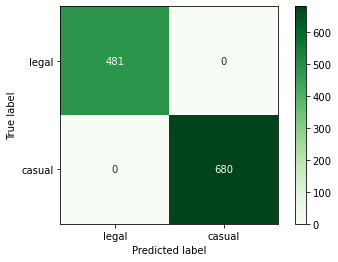

In [55]:
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap='Greens', 
                      values_format='d', display_labels=['legal', 'casual']);

In [ ]:
tn, fp, fn, tp

In [61]:
cm= confusion_matrix(y_test,pred)
df_cm = pd.DataFrame(
cm,index = ['tn','fp'], columns=['fn','fp']
)
df_cm.head()

,fn,fp
tn,481,0
fp,0,680


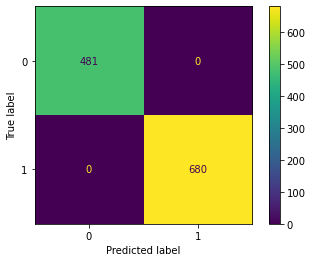

In [60]:
plot_confusion_matrix(logreg, X_test, y_test)

__Logistic regression model using lemmatized words__

In [62]:
# Set up X and y lemmatized words
X = reddit_tvec_lemm_posts
y = reddit['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

__Baseline__

In [63]:
y.value_counts(normalize = True)

1    0.583154
0    0.416846
Name: subreddit, dtype: float64

In [64]:
# Instantiate model
logreg_lemm = LogisticRegression(solver = 'newton-cg')
# Fit the model
logreg_lemm.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [65]:
# training accuracy
logreg_lemm.score(X_train, y_train)

1.0

In [66]:
# testing accuracy
logreg_lemm.score(X_test, y_test)

1.0

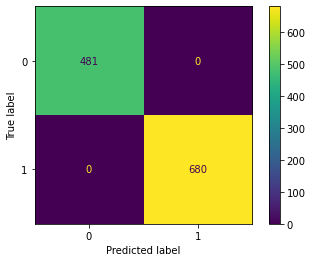

In [67]:
plot_confusion_matrix(logreg_lemm, X_test, y_test)

In [138]:
# Set up X and y stemmed words
X = reddit_tvec_stem_posts
y = reddit['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

__Baseline__

In [139]:
y.value_counts(normalize = True)

1    0.593999
0    0.406001
Name: subreddit, dtype: float64

In [144]:
# Instantiate model
logreg_stem = LogisticRegression(solver = 'newton-cg')
# Fit the model
logreg_stem.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [145]:
# training accuracy
logreg_stem.score(X_train, y_train)

0.7649692221600448

In [146]:
# testing accuracy
logreg_stem.score(X_test, y_test)

0.7768456375838926

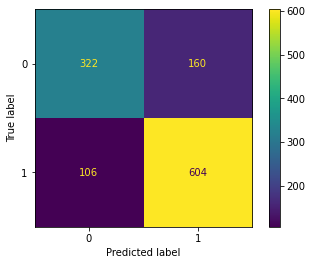

In [147]:
plot_confusion_matrix(logreg_stem, X_test, y_test)

### Train/Test split 

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =123)

### Pipeline 

In [31]:
pipe = Pipeline ([
    ('tvec', TfidfVectorizer()), 
    ('lr', LogisticRegression())
    #('rf', RandomForestClassifier())
])

## GridSearchCV 

In [ ]:
#tokenizer = C

In [149]:
#params = {
    'tvec__stop_words': ['english'],
    'tvec__strip_accents': ['ascii'],
    'tvec__max_features': [200],
    #'tvec__norm': ['l2'],
    'tvec__max_df': [0.8],
    'tvec__min_df': [0.2],
    'tvec__binary': ['False']
    
}
#gs = GridSearchCV(pipe, param_grid = params)
#gs.fit(X_train, y_train)
#print(gs.best_score_)
#gs.best_params_

IndentationError: unexpected indent (<ipython-input-149-0ce2197b6b13>, line 2)

In [ ]:
gs.score(X_test, y_test)

### Model Evaluation 

__confusion matrix__

In [ ]:
pred = gs.predict(X_test)
pred

In [ ]:
(pred != y_test.values).mean()

In [ ]:
X_test[(pred != y_test.values)]

### Random Forest 

In [153]:
#Set up X and y
X = reddit_tvec_posts
y = reddit['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, stratify=y)

In [154]:
rf = RandomForestClassifier(n_estimators=100)

In [155]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.6415831227595933

In [156]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.6544526062173122


{'max_depth': 5, 'n_estimators': 100}

In [157]:
gs.score(X_train, y_train)

0.6827084499160604